In [296]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [297]:
#Import data files

file_activity = "CHEMBI_active_nooutlier.csv"
file_fp = "outlier_cleaned.csv"


df_activity = pd.read_csv(file_activity)
#Load 1*N array of pIC50
activity = df_activity["pIC50"].to_numpy()
#Load N*K array of PCA reduced fingerprint
fp = np.loadtxt(file_fp, delimiter=",")

N = fp.shape[0]
K = fp.shape[1]
print(N,K)

#Define random seed for testing and debugging
np.random.seed(13)

1981 223


In [298]:
#Perform ridge regression using training set in each round of cross validation, output predicted target value and parameters
def Linear_Regression(X_train, X_test, y_train, lam):

    #Add column at front as intercept
    X_train_processed = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    I = np.eye(X_train_processed.shape[1])
    #Initialized the intercept as zero
    I[0, 0] = 0

    #Calculate the closed form solution of feature coefficients
    ridge_variables = np.linalg.inv(X_train_processed.T @ X_train_processed + lam * I) @ X_train_processed.T @ y_train

    #Process the test data as the training data, add column for intercept
    X_test_processed = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
    #predict pIC50 based on the trained model
    y_pred = X_test_processed @ ridge_variables

    return(ridge_variables, y_pred)



In [299]:
cross_folds = 5

#Coordinately shuffle both array 
indices = np.arange(N)
np.random.shuffle(indices)
X = fp[indices]
y = activity[indices]

#Define list of Ridge variables for testing
alphas = np.logspace(-1, 2, 300)
#Initiailize array for recording performance matrices
alpha_models = []
alpha_mse = []
alpha_R2 = []
alpha_rmse = []
alpha_mae = []

split_idx = int(0.8 * len(X))
# Split the indices based on training/testing ratio
train_indices = indices[:split_idx]
val_indices = indices[split_idx:]

# Create the training and validation sets
X_t, X_val = X[train_indices], X[val_indices]
y_t, y_val = y[train_indices], y[val_indices]

#Determine number of sample used in each cross validation spliting group
num_per_group = len(X_t) // cross_folds
#Perform cross validation for each value of ridge coefficient
for k in alphas:
    models_performance = []
    #Perform 5 rounds of validation
    for i in range (cross_folds):
        model_record = {}
        test_start = i * num_per_group
        #Determine starting and ending index for the testing set this round of cross validation
        if i != cross_folds -1:
            test_end= test_start + num_per_group
        else:
            test_end = len(X_t)
        #Split the test and training set based on the determined index
        X_test, y_test = X_t[test_start:test_end], y_t[test_start:test_end]
        #Comebine the leftover data as training set
        X_train = np.concatenate([X_t[:test_start], X_t[test_end:]], axis=0)
        y_train = np.concatenate([y_t[:test_start], y_t[test_end:]], axis=0)
        #Perform Ridge regression on the test/train groups in this fold
        ridge_variables, y_pred = Linear_Regression(X_train, X_test, y_train, k)
        #Calculate performance matrices for this round of validation
        squared_differences = (y_test - y_pred) ** 2
        mse = np.mean(squared_differences)
        model_record["parameters"] = ridge_variables
        model_record["mse"] = mse
        models_performance.append(model_record)

    min_mse = float('inf')  
    best_param = None

    # Loop through each dictionary in the list, find out the parameter with best performance in cross validation
    for dct in models_performance:
        if dct['mse'] < min_mse:
            min_mse = dct['mse']
            best_param = dct['parameters']

    #Calculate the predicted value using validation set
    X_val_processed = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
    Validation_pred = X_val_processed @ best_param
    #Calculate performance matrices using validation set
    squared_differences = (y_val - Validation_pred) ** 2
    mse = np.mean(squared_differences)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_val - Validation_pred))
    r2 = 1 - (np.sum((y_val - Validation_pred) ** 2) / np.sum((y_val - np.mean(y_val)) ** 2))

    #Record the performance matrices and parameters for this alpha value
    alpha_models.append(best_param)
    alpha_mse.append(mse)
    alpha_mae.append(mae)
    alpha_R2.append(r2)
    alpha_rmse.append(rmse)



    

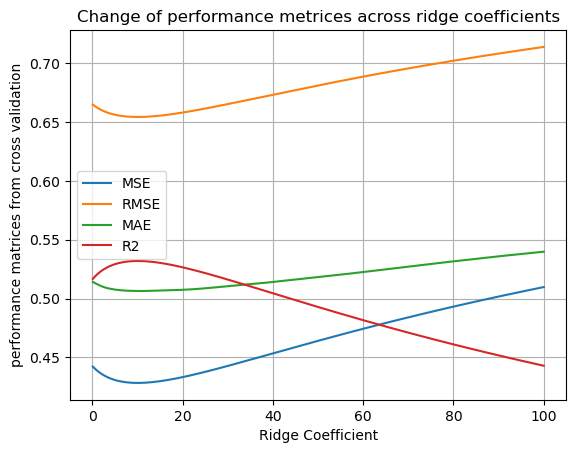

In [300]:
#Plot the performance matrices for different alpha values
alpha_mse = np.array(alpha_mse)
plt.xlabel("Ridge Coefficient")
plt.ylabel("performance matrices from cross validation")
plt.title("Change of performance metrices across ridge coefficients")
plt.plot(alphas, alpha_mse, label = "MSE")  
plt.plot(alphas, alpha_rmse, label = "RMSE") 
plt.plot(alphas, alpha_mae,  label = "MAE") 
plt.plot(alphas, alpha_R2, label = "R2") 
plt.grid(True)
plt.legend()
plt.show()  

In [301]:

#Find out the index of ridge coefficient with smallest mse
best_index = np.argmin(alpha_mse)

#Find the ridge coefficient and corresponding coefficient matrices
best_alpha = alphas[best_index]
best_ridge_parameter = alpha_models[best_index]

#Find out the corresponding performance matrices
best_mse = alpha_mse[best_index]
best_mae = alpha_mae[best_index]
best_rmse = alpha_rmse[best_index]
best_R2 = alpha_R2[best_index]

print("Alpha Value:", best_alpha)
print("MSE, RMSE, R2, MAE:", best_mse, best_rmse, best_R2, best_mae)

#predict the pIC50 using the best model
Final_y_pred = X_val_processed @ best_ridge_parameter


Alpha Value: 9.92328622883255
MSE, RMSE, R2, MAE: 0.4282449621037072 0.6544042803219636 0.5319382702809048 0.506419004061722


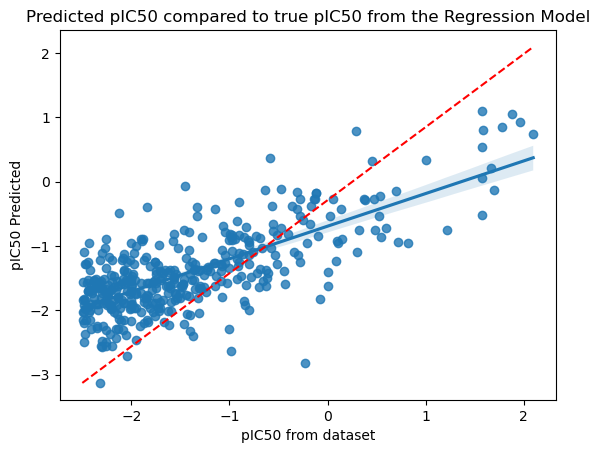

In [307]:
import seaborn as sns

#Plot the image of the validation group, compare target value / predicted value
data = pd.DataFrame({"Test" : y_val, "Predicted" : Final_y_pred})

ax = sns.regplot(x='Test', y='Predicted', data = data)
min_val = min(y_val.min(), Final_y_pred.min())
max_val = max(y_val.max(), Final_y_pred.max())

# Plot the diagonal line
plt.plot([-2.5, max_val], [min_val, max_val], color='red', linestyle='--')
plt.title("Predicted pIC50 compared to true pIC50 from the Regression Model")
plt.xlabel("pIC50 from dataset")
plt.ylabel("pIC50 Predicted")
plt.show()
